# Modeling Notebook

Welcome to the second part of our project, focused on Implementing Machine Learning Models. In this phase, we embark on the last three stages of the data analytics lifecycle, aiming to discover the most effective algorithm for predicting heart disease based on the available features. 

This Jupyter Notebook serves as your guide through a series of implementations, where we explore various algorithms and models. From data preparation to model evaluation, we traverse each step, endeavoring to create robust and efficient machine learning models tailored to our specific task. Let's dive in and explore the journey of discovering the optimal model for predicting heart disease.

In [36]:
import os
import pickle
import random
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms
import umap
from imblearn.combine import SMOTEENN
from plotly.figure_factory._dendrogram import sch
from pycm import ConfusionMatrix
from scipy.stats import ttest_ind, probplot, shapiro
from sklearn.base import clone
from sklearn.cluster import KMeans, OPTICS
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.models import Sequential
from mlxtend.feature_selection import SequentialFeatureSelector

warnings.filterwarnings("ignore")

In [2]:
class DataLoader:
    """
    Generic Class responsible for loading the dataset

    Attributes:
        filename (str): The filename of the dataset to load.
        target (str): The target of the dataset to load.

    Attributes (after loading the data):
        data (DataFrame): The main dataset containing both features and target variable.
        labels (DataFrame): The target variable.
        numerical_features (List): List of numerical features in the dataset.
        categorical_features (List): List of categorical features in the dataset.


    Methods:
        _load_data(): Loads the dataset,and assigns the data and labels to the appropriate attributes.
    """

    def __init__(self, filename, target):
        """
        Initializes the DataLoader with the filename of the dataset.

        Args:
            filename (str): The filename of the dataset to load.
            target (str): The target of the dataset to load.
        """
        self.filename = filename

        self.data = None
        self.target = target
        self.labels = None
        self.numerical_features = []
        self.categorical_features = []

        # Load data
        self._load_data(target)

    def _load_data(self, target):
        """
        Loads the dataset from the specified filename,
        and assigns the data and labels to the appropriate attributes.

        Args:
            target (str): The target of the dataset to load.
        """
        try:
            # Load the dataset
            self.data = pd.read_csv(self.filename)

            # Validate if the target column exists in the dataset
            if target not in self.data.columns:
                raise ValueError(f"Target column '{target}' not found in the dataset.")

            self.labels = self.data[target]

            print("Data loaded successfully.")

        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [3]:
class DataManipulator(DataLoader):
    """
    A class for manipulating data loaded from a file.

    Args:
        filename (str): The path to the data file.
        target (str): The target variable in the data.

    Attributes:
        data (DataFrame): The loaded data.

    Methods:
        _describe_variables: Prints information about the data, including data info, unique values, and statistical distribution.

    Raises:
        FileNotFoundError: If the specified file is not found.

    """

    def __init__(self, filename, target):
        """
        Initialize the class with a filename and target variable.

        Args:
            filename (str): The path to the file.
            target (str): The name of the target variable.

        Raises:
            FileNotFoundError: If the file is not found.

        """
        try:
            super().__init__(filename, target)
            print("\nData Description:")
            self._describe_variables()
        except FileNotFoundError:
            print("File not found. Please check the file path.")

    def _describe_variables(self):
        """
        Prints information about the data, including data info, unique values, and statistical distribution.
        """
        print("\nInformation of Data:")
        print(self.data.info())

        print("\nUnique values of features:")
        print(self.data.nunique())

        print("\nStatistical distribution of each variable:")
        print(self.data.describe())

    def update_data(self, filename):
        """
        Updates the data attribute with the data from the specified file.

        Args:
            filename (str): The path to the file.

        Raises:
            FileNotFoundError: If the file is not found.

        """
        try:
            self.data = pd.read_csv(filename)
            print("Data updated successfully.")
        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [4]:
class KNearestNeighbors:
    """
    K-Nearest Neighbors classifier.
    
    Parameters:
        - k (int): Number of neighbors to consider.
        - radius (float): Radius for radius search. Default is 30.
    
    Attributes:
        - k (int): Number of neighbors to consider.
        - radius (float): Radius for radius search.
        - nbrs (object): NearestNeighbors object.
        - y_train (array-like): Training labels.
        
    Methods:
        - fit(X_train, y_train): Fit the model to the training data.
        - score(X_val, y_val): Calculate the accuracy of the model on the validation data.
        - predict(X_val): Predict the labels for the validation data.
    """
    def __init__(self, k, radius=30):
        """
        Initialize the KNearestNeighbors object.
        
        Parameters:
            - k (int): Number of neighbors to consider.
            - radius (float): Radius for radius search. Default is 30.
        """
        self.k = k
        self.radius = radius
        self.nbrs = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """
        Fit the model to the training data.

        Parameters:
            - X_train (array-like): Training data.
            - y_train (array-like): Training labels.
        """
        # Initialize NearestNeighbors object with algorithm='ball_tree' for efficient nearest neighbor search
        self.nbrs = NearestNeighbors(n_neighbors=self.k, algorithm='ball_tree').fit(X_train)
        self.y_train = y_train

    def score(self, X_val, y_val):
        """
        Calculate the accuracy of the model on the validation data.

        Parameters:
            - X_val (array-like): Validation data.
            - y_val (array-like): Validation labels.

        Returns:
            - float: Accuracy of the model on the validation data.

        Raises:
            - ValueError: If the model has not been trained yet.
        """
        if self.nbrs is None:
            raise ValueError("Model has not been trained yet. Please call fit() before score().")

        # Perform radius search for each validation data point
        _, indices = self.nbrs.radius_neighbors(X_val, self.radius)

        correct_counts = 0
        total_counts = len(X_val)

        # Iterate through each validation data point and count correct predictions
        for i in range(total_counts):

            neighbor_labels = self.y_train[indices[i]]  # Get labels of neighbors within the radius

            while len(neighbor_labels) < self.k:  # If the number of neighbors is less than k
                self.radius += 3  # Increase the radius
                _, indices = self.nbrs.radius_neighbors(X_val, self.radius)  # Perform radius search again
                neighbor_labels = self.y_train[indices[i]] # Get labels of neighbors within the new radius

            predicted_label = np.bincount(neighbor_labels).argmax()  # Predict label based on majority vote
            if predicted_label == y_val[i]:  # Check if prediction matches the true label
                correct_counts += 1

        accuracy = correct_counts / total_counts  # Calculate accuracy
        return accuracy

    def predict(self, X_val):
        """
        Predict the labels for the validation data.

        Parameters:
            - X_val (array-like): Validation data.

        Returns:
            - array: Predicted labels for the validation data.

        Raises:
            - ValueError: If the model has not been trained yet.
        """
        if self.nbrs is None:
            raise ValueError("Model has not been trained yet. Please call fit() before predict().")

        # Perform radius search for each validation data point
        _, indices = self.nbrs.radius_neighbors(X_val, self.radius)

        y_pred = []

        # Iterate through each validation data point and make predictions
        for i in range(len(X_val)):

            neighbor_labels = self.y_train[indices[i]]  # Get labels of neighbors within the radius

            while len(neighbor_labels) < self.k:  # If the number of neighbors is less than k
                self.radius += 3  # Increase the radius
                _, indices = self.nbrs.radius_neighbors(X_val, self.radius)  # Perform radius search again
                neighbor_labels = self.y_train[indices[i]]  # Get labels of neighbors within the new radius

            predicted_label = np.bincount(neighbor_labels).argmax()  # Predict label based on majority vote
            y_pred.append(predicted_label)

        return np.array(y_pred)

In [5]:
class ModelOptimization:
    """
    Class for optimizing the parameters of different classifiers.

    Parameters:
        - X_train (array-like): Training data.
        - y_train (array-like): Training labels.
        - X_val (array-like): Validation data.
        - y_val (array-like): Validation labels.

    Attributes:
        - X_train (array-like): Training data.
        - y_train (array-like): Training labels.
        - X_val (array-like): Validation data.
        - y_val (array-like): Validation labels.

    Methods:
        optimize_knn: Optimizes the parameters for K-Nearest Neighbors classifier.
        optimize_logistic_regression: Optimizes the parameters for Logistic Regression classifier.
        optimize_decision_tree: Optimizes the parameters for Decision Tree classifier.
        optimize_mlp: Optimizes the parameters for Multi-layer Perceptron (MLP) classifier.
    """

    def __init__(self, X_train, y_train, X_val, y_val):
        """
        Initialize the ModelOptimization object.

        Parameters:
            - X_train (array-like): Training data.
            - y_train (array-like): Training labels.
            - X_val (array-like): Validation data.
            - y_val (array-like): Validation labels.

        Attributes:
            - X_train (array-like): Training data.
            - y_train (array-like): Training labels.
            - X_val (array-like): Validation data.
            - y_val (array-like): Validation labels.
        """

        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def optimize_knn(self, k_values):
        """
        Optimizes the parameters for K-Nearest Neighbors classifier.

        Parameters:
            k_values (list): List of k values to try.

        Returns:
            int: Best k value.
        """

        best_k = None
        best_accuracy = -1

        for k in k_values:

            knn = KNearestNeighbors(k)
            knn.fit(self.X_train, self.y_train)  # Fit the model to the training data
            accuracy = knn.score(self.X_val, self.y_val)  # Calculate the accuracy on the validation data
            print(f"k = {k}, Accuracy = {accuracy}")  # Print the accuracy for the current k value

            if accuracy > best_accuracy:  # Update the best k value if the accuracy is higher
                best_accuracy = accuracy
                best_k = k

        print("Best k value:", best_k)
        print("Best accuracy:", best_accuracy)
        return best_k

    def optimize_logistic_regression(self, C_values=(0.01, 0.1, 1.0, 10.0), penalty=('l1', 'l2')):
        """
        Optimizes the parameters for Logistic Regression classifier.

        Parameters:
            C_values (tuple): Values to try for regularization parameter C. Default is (0.01, 0.1, 1.0, 10.0).
            penalty (tuple): Penalty values to try. Default is ('l1', 'l2').

        Returns:
            tuple: Best parameters for Logistic Regression (C, penalty).
        """
        best_accuracy = -1
        best_c = None
        best_penalty = None

        for c in C_values:
            for penalty_selected in penalty:

                lr = LogisticRegression(C=c, penalty=penalty_selected, solver='saga', multi_class='auto', max_iter=1000)
                lr.fit(self.X_train, self.y_train)  # Fit the model to the training data
                accuracy = lr.score(self.X_val, self.y_val)  # Calculate the accuracy on the validation data

                print(f"C = {c}, Penalty = {penalty_selected}, Accuracy = {accuracy}")

                if accuracy > best_accuracy:  # Update the best parameters if the accuracy is higher
                    best_accuracy = accuracy
                    best_c = c
                    best_penalty = penalty_selected

        print("Best c value:", best_c)
        print("Best penalty:", best_penalty)
        print("Best accuracy:", best_accuracy)
        return best_c, best_penalty

    def optimize_decision_tree(self, max_depth_values=(None, 5, 10, 20)):
        """
        Optimizes the parameters for Decision Tree classifier.

        Parameters:
            max_depth_values (tuple): Values to try for max depth. Default is (None, 5, 10, 20).

        Returns:
            int: Best max depth value.
        """
        best_accuracy = -1
        best_max_depth = None

        for max_depth in max_depth_values:  # Iterate over the max depth values

            dt = DecisionTreeClassifier(max_depth=max_depth)
            dt.fit(self.X_train, self.y_train)  # Fit the model to the training data
            accuracy = dt.score(self.X_val, self.y_val)  # Calculate the accuracy on the validation data

            print(f"Max depth = {max_depth}, Accuracy = {accuracy}")

            if accuracy > best_accuracy:  # Update the best max depth value if the accuracy is higher
                best_accuracy = accuracy
                best_max_depth = max_depth

        print("Best max depth value:", best_max_depth)
        print("Best accuracy:", best_accuracy)
        return best_max_depth

    def optimize_mlp(self, population_size=20, max_generations=50, layer_range=(1, 100), activation=('logistic', 'tanh')):
        """
        Optimizes the parameters for Multi-layer Perceptron (MLP) classifier.

        Parameters:
            population_size (int): Number of individuals in the population. Default is 20.
            max_generations (int): Maximum number of generations. Default is 50.
            layer_range (tuple): Range of values to try for the number of neurons in the hidden layer. Default is (1, 100).
            activation (tuple): Activation functions to try. Default is ('logistic', 'tanh').

        Returns:
            tuple: Best parameters for MLP (neurons, activation).
        """
        # Initialize the population
        population = []
        # Generate random individuals
        for _ in range(population_size):

            neurons = random.randint(*layer_range)
            activation_selected = random.choice(activation)
            population.append((neurons, activation_selected))

        # Random evolutionary search
        for generation in range(max_generations):

            print(f"Generation {generation + 1}/{max_generations}")
            new_population = []  # Initialize the new population
            for i, (neurons, activation_selected) in enumerate(population):  # Iterate over the population

                # Skip the first iteration from generation 1 onwards since it is the best elements foun on the previous iteration
                if generation != 0 and i == 0:
                    new_population.append((best_params, best_accuracy))
                    continue

                print("Generation ", generation, " element ", i)  # Print the generation and element number
                mlp = MLPClassifier(hidden_layer_sizes=(neurons,), activation=activation_selected, early_stopping=True)
                mlp.fit(self.X_train, self.y_train)  # Fit the model to the training data
                accuracy = mlp.score(self.X_val, self.y_val)  # Calculate the accuracy on the validation data
                new_population.append(((neurons, activation_selected), accuracy))  # Add the individual to the new population
                print(f"Neurons: {neurons}, activation: {activation_selected}, Accuracy: {accuracy}")

            new_population.sort(key=lambda x: x[1], reverse=True)
            # Keep only the best element (concept of elitism in genetic algorithm)
            best_params, best_accuracy = new_population[0]
            population = [best_params]

            # Use the parameters of the best individual to bias the generation of new individuals
            best_neurons, best_activation = best_params

            # Break when only 2 individuals are left
            if population_size <= 2:
                break
            population_size -= 1

            # Generate the new population
            for _ in range(1, population_size):
                # Randomly generate neurons with a bias towards the best_neurons
                neurons = random.randint(np.ceil(best_neurons - 20) + 1, best_neurons + 20)
                # Randomly select activation function
                activation_selected = random.choice(activation)
                population.append((neurons, activation_selected))

        print("Best MLP parameters:", best_params)
        print("Best accuracy:", best_accuracy)
        return best_params

In [6]:
class CrossValidator:
    """
    Class for performing k-fold cross-validation on machine learning models.

    Parameters:
        k (int): Number of folds for cross-validation. Default is 5.

    Attributes:
        k (int): Number of folds for cross-validation.
        kf (object): KFold object for splitting the data.
        cm (object): ConfusionMatrix object for calculating confusion matrix.
        accuracy_scores (list): List of accuracy scores for each fold.
        sensitivity_scores (list): List of sensitivity scores for each fold.
        specificity_scores (list): List of specificity scores for each fold.

    Methods:
        cross_validate: Performs k-fold cross-validation on the model.
        evaluate_on_test_set: Evaluates the trained model on the test set.
    """

    def __init__(self, k=5):
        """
        Initialize the CrossValidator object.

        Parameters:
            k (int): Number of folds for cross-validation. Default is 5.

        Attributes:
            k (int): Number of folds for cross-validation.
            kf (object): KFold object for splitting the data.
            cm (object): ConfusionMatrix object for calculating confusion matrix.
            accuracy_scores (list): List of accuracy scores for each fold.
            sensitivity_scores (list): List of sensitivity scores for each fold.
            specificity_scores (list): List of specificity scores for each fold.
        """

        self.k = k
        self.kf = KFold(n_splits=k, shuffle=True)
        self.cm = None
        self.accuracy_scores = []
        self.sensitivity_scores = []
        self.specificity_scores = []

    def cross_validate(self, model, X, y):
        """
        Performs k-fold cross-validation on the model.

        Parameters:
            model: Machine learning model.
            X (array-like): Features.
            y (array-like): Labels.

        Returns:
            tuple: Average accuracy, sensitivity, and specificity scores.
        """

        for train_index, val_index in self.kf.split(X):  # Split the data into training and validation sets
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model.fit(X_train, y_train)  # Fit the model to the training data
            y_pred = model.predict(X_val)  # Predict the labels for the validation data

            self.cm = ConfusionMatrix(actual_vector=list(y_val), predict_vector=list(y_pred))

            self.accuracy_scores.append(accuracy_score(y_val, y_pred))
            self.sensitivity_scores.append(float(self.cm.TPR_Macro))
            self.specificity_scores.append(float(self.cm.TNR_Macro))

        avg_accuracy = sum(self.accuracy_scores) / len(self.accuracy_scores)
        avg_sensitivity = sum(self.sensitivity_scores) / len(self.sensitivity_scores)
        avg_specificity = sum(self.specificity_scores) / len(self.specificity_scores)

        return avg_accuracy, avg_sensitivity, avg_specificity

    def evaluate_on_test_set(self, model, X_test, y_test):
        """
        Evaluates the trained model on the test set.

        Parameters:
            model: Trained machine learning model.
            X_test (array-like): Test features.
            y_test (array-like): Test labels.

        Returns:
            tuple: Accuracy, sensitivity, and specificity scores on the test set.
        """

        y_pred = model.predict(X_test)
        cm = ConfusionMatrix(actual_vector=list(y_test), predict_vector=list(y_pred))
        accuracy = cm.Overall_ACC
        sensitivity = cm.TPR_Macro
        specificity = cm.TNR_Macro
        return accuracy, sensitivity, specificity

In [19]:
class ModelBuilding:
    """
    Class for building, optimizing and evaluating machine learning models.

    Parameters:
        X_train (array-like): Training data.
        y_train (array-like): Training labels.
        X_test (array-like): Test data.
        y_test (array-like): Test labels.
        X_val (array-like): Validation data.
        y_val (array-like): Validation labels.
        k (int): Number of folds for cross-validation. Default is 5.
        save_all (bool): Flag to save all models. Default is True.

    Attributes:
        X_train (array-like): Training data.
        y_train (array-like): Training labels.
        X_test (array-like): Test data.
        y_test (array-like): Test labels.
        X_val (array-like): Validation data.
        y_val (array-like): Validation labels.
        k (int): Number of folds for cross-validation.
        save_all (bool): Flag to save all models.
        best_model (object): Best performing model.
        best_model_name (str): Name of the best performing model.
        best_params (tuple): Best parameters for the best performing model.
        best_score (float): Best validation score.
        best_model_changed (bool): Flag to track if the best model changed.
        history (dict): Dictionary to store the validation scores of all models.

    Methods:
        build_models: Builds, optimizes and evaluates machine learning models.
        evaluate_best_model: Evaluates the best model on the test set.
        save_model: Saves the model to a file.
    """

    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, k=5, save_all=True):
        """
        Initialize the ModelBuilding object.

        Parameters:
            X_train (array-like): Training data.
            y_train (array-like): Training labels.
            X_test (array-like): Test data.
            y_test (array-like): Test labels.
            X_val (array-like): Validation data.
            y_val (array-like): Validation labels.
            k (int): Number of folds for cross-validation. Default is 5.
            save_all (bool): Flag to save all models. Default is True.

        Attributes:
            X_train (array-like): Training data.
            y_train (array-like): Training labels.
            X_test (array-like): Test data.
            y_test (array-like): Test labels.
            X_val (array-like): Validation data.
            y_val (array-like): Validation labels.
            k (int): Number of folds for cross-validation.
            save_all (bool): Flag to save all models.
            best_model (object): Best performing model.
            best_model_name (str): Name of the best performing model.
            best_params (tuple): Best parameters for the best performing model.
            best_score (float): Best validation score.
            best_model_changed (bool): Flag to track if the best model changed.
            history (dict): Dictionary to store the validation scores of all models.
        """

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val
        self.k = k
        self.save_all = save_all
        self.best_model = None
        self.best_model_name = None
        self.best_params = None
        self.best_score = -1
        self.best_model_changed = False
        self.history = {}

    def build_models(self, model_name, models_dict, results_dict):
        """
        Builds, optimizes and evaluates machine learning models.

        Parameters:
            model_name (str): Name of the model to build.
            models_dict (dict): Dictionary containing the models to build.
            results_dict (dict): Dictionary to store the results of the models.

        Raises:
            ValueError: If the model type is not supported.
        """

        model_optimization = ModelOptimization(self.X_train, self.y_train, self.X_val, self.y_val)
        print("\nTraining", model_name, "model")
        for name, model_params in models_dict.items():  # Iterate over the models
            if model_name != name:
                continue
            model = model_params.pop('model')
            model_params_check = {}

            if model_name == "KNN":  # Optimize the parameters for K-Nearest Neighbors
                k = model_optimization.optimize_knn(model_params['k'])
                model_params_check['k'] = k
                params = {'k': k}
            elif model_name == "LogisticRegression":  # Optimize the parameters for Logistic Regression
                lr_params = model_optimization.optimize_logistic_regression(**model_params)
                model_params_check['C'] = lr_params[0]
                model_params_check['penalty'] = lr_params[1]
                params = lr_params
            elif model_name == "DecisionTree":  # Optimize the parameters for Decision Tree
                dt_params = model_optimization.optimize_decision_tree(**model_params)
                model_params_check['max_depth'] = dt_params
                params = dt_params
            elif model_name == "MLP":  # Optimize the parameters for Multi-layer Perceptron (MLP)
                mlp_params = model_optimization.optimize_mlp(**model_params)
                model_params_check['hidden_layer_sizes'] = (mlp_params[0],)
                model_params_check['activation'] = mlp_params[1]
                params = mlp_params
            else:
                raise ValueError("Model type is not supported.")

            model_instance = model(**model_params_check)  # Create an instance of the model with the optimized parameters
            model_instance.fit(self.X_train, self.y_train)  # Fit the model to the training data
            val_score = model_instance.score(self.X_val, self.y_val)  # Calculate the accuracy on the validation data
            self.history[str(name)] = val_score  # Store the validation score in the history dictionary

            if val_score > self.best_score:  # Update the best model if the validation score is higher
                print("\nNew best model found!")
                self.best_score = val_score
                self.best_model = model_instance
                self.best_model_name = name
                self.best_params = params
                self.best_model_checked = model
                self.best_model_params_checked = model_params_check
                self.best_model_changed = True  # Update flag when a new best model is found
            else:
                self.best_model_changed = False  # Reset flag if the best model didn't change

            if self.save_all:  # Save all models if the flag is set
                self.save_model(model_instance, name)

        self.kf_cv = CrossValidator(k=self.k)

        print(f"\nPreforming cross-validation on the {model_name} model:")

        # Performance of the model during cross-validation
        avg_accuracy_cv, avg_sensitivity_cv, avg_specificity_cv = self.kf_cv.cross_validate(model_instance,
                                                                                            self.X_train, self.y_train)

        print("Average accuracy during cross-validation:", avg_accuracy_cv)
        print("Average sensitivity during cross-validation:", avg_sensitivity_cv)
        print(f"Average specificity during cross-validation: {avg_specificity_cv}\n")

        print(f"\nPerformance of the {model_name} model on the Test set:")

        # Performance of the model on the test set
        accuracy_test, sensitivity_test, specificity_test = self.kf_cv.evaluate_on_test_set(model_instance, self.X_test,
                                                                                            self.y_test)
        print("Test set accuracy:", accuracy_test)
        print("Test set sensitivity:", sensitivity_test)
        print(f"Test set specificity: {specificity_test}\n")

        # Store the results in the results dictionary
        results_dict[model_name]['Accuracy'] = float(accuracy_test)
        results_dict[model_name]['Sensitivity'] = float(sensitivity_test)
        results_dict[model_name]['Specificity'] = float(specificity_test)

        # Print the best model and its parameters
        print("\nOptimization finished, history:\n")
        print("Model name\t\tAccuracy")
        for model, accuracy in self.history.items():
            print(f"{model}\t\t{accuracy}")
        print("\nBest performing model:", self.best_model_name)
        print("Best validation score:", self.best_score)
        print("Best parameters:", self.best_params)

        if not self.save_all:  # Save the best model if the flag is not set
            self.save_model(self.best_model, self.best_model_name)

    def save_model(self, model, filename):
        """
        Saves the model to a file.

        Parameters:
            model: Trained machine learning model.
            filename (str): Name of the file to save the model.
        """

        folder_path = "../models"
        full_path = os.path.join(folder_path, filename)
        print("Saving model as", filename)
        joblib.dump(model, full_path)

In [8]:
class BaggingClassifier:
    """
    A class for implementing the Bagging ensemble method with a base model.

    Parameters:
        base_model: Base machine learning model to use for bagging (Best Model).
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.
        n_straps (int): Number of bootstrap samples. Default is 100.
        k_fold (int): Number of folds for cross-validation. Default is 5.

    Attributes:
        base_model: Base machine learning model to use for bagging.
        n_straps (int): Number of bootstrap samples.
        k_fold (int): Number of folds for cross-validation.
        models (list): List of trained models.
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.
        accuracy_scores (list): List of accuracy scores.
        sensitivity_scores (list): List of sensitivity scores.
        specificity_scores (list): List of specificity scores.
        avg_accuracy (float): Average accuracy score.
        avg_sensitivity (float): Average sensitivity score.
        avg_specificity (float): Average specificity score.

    Methods:
        examine_bagging: Fits the bagging ensemble on the training data with k fold cross-validation.
        predict: Predicts class labels for input data.
        evaluate: Evaluates the bagging ensemble on test data.
    """

    def __init__(self, base_model, X_train, y_train, X_test, y_test, n_straps=100, k_fold=5):

        self.base_model = base_model
        self.n_straps = n_straps
        self.k_fold = k_fold
        self.models = []
        self.X_train, self.y_train = X_train, y_train
        self.X_test = X_test
        self.y_test = y_test
        self.accuracy_scores = []
        self.sensitivity_scores = []
        self.specificity_scores = []
        self.avg_accuracy = None
        self.avg_sensitivity = None
        self.avg_specificity = None

    def examine_bagging(self):
        """
        Fits the bagging ensemble on the training data with k fold cross-validation.

        Returns:
            tuple: Average accuracy, sensitivity, and specificity scores.
        """
        kfold = KFold(n_splits=self.k_fold, shuffle=True)
        for train_index, val_index in kfold.split(self.X_train):
            # Generate n_straps samples and train the models for the current fold
            self.models = []
            for _ in range(self.n_straps):
                # Create bootstrap sample with the available indices of the fold
                bootstrap_indices = np.random.choice(train_index, size=len(self.X_train[train_index]), replace=True)
                X_bootstrap = self.X_train[bootstrap_indices]
                y_bootstrap = self.y_train[bootstrap_indices]

                # Train base model on bootstrap sample
                model = clone(self.base_model)
                model.fit(X_bootstrap, y_bootstrap)
                self.models.append(model)

            y_pred = self.predict(self.X_train[val_index])

            self.cm = ConfusionMatrix(actual_vector=list(self.y_train[val_index]), predict_vector=list(y_pred))
            self.accuracy_scores.append(accuracy_score(self.y_train[val_index], y_pred))
            print(self.cm)
            self.sensitivity_scores.append(float(self.cm.TPR_Macro))
            self.specificity_scores.append(float(self.cm.TNR_Macro))

        self.avg_accuracy = sum(self.accuracy_scores) / len(self.accuracy_scores)
        self.avg_sensitivity = sum(self.sensitivity_scores) / len(self.sensitivity_scores)
        self.avg_specificity = sum(self.specificity_scores) / len(self.specificity_scores)

        return self.avg_accuracy, self.avg_sensitivity, self.avg_specificity

    def predict(self, X):
        """
        Predicts class labels for input data.

        Parameters:
            X (array-like): Features.

        Returns:
            array-like: Predicted class labels.
        """
        # Aggregate predictions from all models
        predictions = np.zeros((len(X), self.n_straps))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)

        # Use majority voting to determine final prediction
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
        return final_predictions

    def evaluate(self, results_dict):
        """
        Evaluates the bagging ensemble on test data.

        Parameters:
            results_dict (dict): Dictionary to store the results of the models.
        """
        self.y_pred = self.predict(self.X_test)
        self.cm = ConfusionMatrix(actual_vector=list(self.y_test), predict_vector=list(self.y_pred))
        self.accuracy_scores = accuracy_score(self.y_test, self.y_pred)
        self.sensitivity_scores = float(self.cm.TPR_Macro)
        self.specificity_scores = float(self.cm.TNR_Macro)

        results_dict['Bagging']['Accuracy'] = float(self.accuracy_scores)
        results_dict['Bagging']['Sensitivity'] = float(self.sensitivity_scores)
        results_dict['Bagging']['Specificity'] = float(self.specificity_scores)

        print(f"Accuracy: {self.accuracy_scores}, Sensitivity: {self.sensitivity_scores}, Specificity: {self.specificity_scores}")

In [37]:
class AdaBoostClassifier:
    """
    A class for implementing the AdaBoost ensemble method with a base model.

    Parameters:
        best_model: Best model to use for AdaBoost.
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.
        builder (object): Builder object with the configurations of the model.
        n_estimators (int): Number of weak learners. Default is 50.
        learning_rate (float): Learning rate shrinks the contribution of each weak learner. Default is 1.0.
        k_fold (int): Number of folds for cross-validation. Default is 5.

    Attributes:
        best_model: Best model to use for AdaBoost.
        n_estimators (int): Number of weak learners.
        learning_rate (float): Learning rate shrinks the contribution of each weak learner.
        k_fold (int): Number of folds for cross-validation.
        models (list): List of trained models.
        X_train (array-like): Training features.
        y_train (array-like): Training labels.
        X_test (array-like): Test features.
        y_test (array-like): Test labels.
        accuracy_scores (list): List of accuracy scores.
        sensitivity_scores (list): List of sensitivity scores.
        specificity_scores (list): List of specificity scores.
        builder (object): Builder object with the configurations of the model.
        avg_accuracy (float): Average accuracy score.

    Methods:
        train_adaboost: Trains the AdaBoost ensemble on the training data with k fold cross-validation.
        predict: Predicts class labels for input data.
        evaluate: Evaluates the AdaBoost ensemble on test data.
    """
    def __init__(self, best_model, X_train, y_train, X_test, y_test, builder, n_estimators=50, learning_rate=1.0, k_fold=5):

        self.best_model = best_model
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.k_fold = k_fold
        self.models = []
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test
        self.accuracy_scores = []
        self.sensitivity_scores = []
        self.specificity_scores = []
        self.builder = builder
        self.avg_accuracy = None

    def train_adaboost(self):
        """
        Trains the AdaBoost ensemble on the training data with k fold cross-validation.

        Returns:
            float: Average accuracy score.
        """
        kfold = KFold(n_splits=self.k_fold, shuffle=True)
        for train_index, val_index in kfold.split(self.X_train):
            # Initialize weights
            w = np.ones(len(train_index)) / len(train_index)

            models = []
            for level in range(self.n_estimators):
                print("Level ", level, " of ", self.n_estimators-1)
                # Train base model with weighted samples

                base_model = None

                if (self.best_model == 'KNN'):

                    base_model = KNeighborsClassifier(n_neighbors=self.builder.best_model_params_checked['n_neighbors'])

                elif (self.best_model == 'LogisticRegression'):

                    base_model = LogisticRegression(C=self.builder.best_model_params_checked['C'],
                                                    penalty=self.builder.best_model_params_checked['penalty'])

                elif (self.best_model == 'DecisionTree'):

                    base_model = DecisionTreeClassifier(max_depth=self.builder.best_model_params_checked['max_depth'])

                elif (self.best_model == 'MLP'):

                    base_model = MLPClassifier(hidden_layer_sizes=self.builder.best_model_params_checked['hidden_layer_sizes'],
                                            activation=self.builder.best_model_params_checked['activation'], early_stopping=True)
                else:
                    raise ValueError("Best model not found.")

                # Train the model
                base_model.fit(self.X_train[train_index], self.y_train[train_index], sample_weight=w)

                print("Examining model")
                # Compute error
                y_pred = base_model.predict(self.X_train[train_index])
                err = np.sum(w * (y_pred != self.y_train[train_index])) / np.sum(w)

                print("Updating Adaboost model")
                # Compute alpha
                alpha = self.learning_rate * np.log((1 - err) / err)

                # Update weights
                w *= np.exp(alpha * (y_pred != self.y_train[train_index]))

                models.append((base_model, alpha))

            self.models.append(models)

            # Compute predictions for validation set
            y_pred = self.predict(val_index)

            # Evaluate performance
            self.accuracy_scores.append(accuracy_score(self.y_train[val_index], y_pred))
            print("Accuracy:", self.accuracy_scores[-1])

        self.avg_accuracy = sum(self.accuracy_scores) / len(self.accuracy_scores)

        return self.avg_accuracy

    def predict(self, index):
        """
        Predicts class labels for input data.

        Parameters:
            index (array-like): Indices of the data to predict.

        Returns:
            array-like: Predicted class labels.
        """
        num_classes = len(np.unique(self.y_train))
        predictions = np.zeros((len(index), num_classes))
        for model, alpha in self.models[-1]:
            y_pred = model.predict(self.X_train[index])
            # Adjust the size of predictions array to match the expected size
            temp_predictions = np.zeros((len(index), num_classes))
            # Iterate over each sample and increment the corresponding class prediction
            for i, pred in enumerate(y_pred):
                temp_predictions[i, int(pred)] += alpha
            predictions += temp_predictions

        final_predictions = np.argmax(predictions, axis=1)
        return final_predictions

    def evaluate(self, results_dict):
        """
        Evaluates the AdaBoost ensemble on test data.

        Parameters:
            results_dict (dict): Dictionary to store the results of the models.

        Returns:
            float: Accuracy score.
        """
        num_classes = len(np.unique(self.y_train))
        predictions = np.zeros((len(self.y_test), num_classes))
        for model, alpha in self.models[-1]:
            y_pred = model.predict(self.X_test)
            temp_predictions = np.zeros((len(self.y_test), num_classes))
            for i, pred in enumerate(y_pred):
                temp_predictions[i, int(pred)] += alpha
            predictions += temp_predictions
        final_predictions = np.argmax(predictions, axis=1)

        # Calculate confusion matrix
        cm = ConfusionMatrix(actual_vector=list(self.y_test), predict_vector=list(final_predictions))
        sensitivity_boost = cm.TPR_Macro
        specificity_boost = cm.TNR_Macro

        # Calculated accuracy
        accuracy_boost = accuracy_score(self.y_test, final_predictions)
        
        # Accuracy Scores
        print(f"\nAccuracy Scores: {self.accuracy_scores}")

        # Calculated accuracy
        print(f"\nTest Accuracy: {accuracy_boost}")
        
        # Calculated sensitivity
        print(f"Test Sensitivity: {sensitivity_boost}")

        # Calculated specificity
        print(f"Test Specificity: {specificity_boost}\n")

        # Store the results in the results dictionary
        results_dict['AdaBoost']['Accuracy'] = float(accuracy_boost)
        results_dict['AdaBoost']['Sensitivity'] = float(sensitivity_boost)
        results_dict['AdaBoost']['Specificity'] = float(specificity_boost)

In [10]:
class CNN:
    """
    A class to implement a Convolutional Neural Network (CNN) for binary classification.

    Parameters:
        X_train (array-like): Training data.
        y_train (array-like): Training labels.
        X_test (array-like): Test data.
        y_test (array-like): Test labels.
        X_val (array-like): Validation data.
        y_val (array-like): Validation labels.
        input_shape (tuple): Shape of the input data.
        num_classes (int): Number of classes.
        epochs (int): Number of epochs. Default is 10.
        batch_size (int): Batch size. Default is 32.

    Attributes:
        X_train (array-like): Training data.
        y_train (array-like): Training labels.
        X_test (array-like): Test data.
        y_test (array-like): Test labels.
        X_val (array-like): Validation data.
        y_val (array-like): Validation labels.
        input_shape (tuple): Shape of the input data.
        num_classes (int): Number of classes.
        epochs (int): Number of epochs.
        batch_size (int): Batch size.
        model (object): CNN model.

    Methods:
        build_model: Builds the CNN model.
        train: Trains the CNN model.
        evaluate: Evaluates the CNN model.
    """

    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, input_shape, num_classes, epochs=10, batch_size=32):
        """
        Initialize the CNN object.

        Parameters:
            X_train (array-like): Training data.
            y_train (array-like): Training labels.
            X_test (array-like): Test data.
            y_test (array-like): Test labels.
            X_val (array-like): Validation data.
            y_val (array-like): Validation labels.
            input_shape (tuple): Shape of the input data.
            num_classes (int): Number of classes.
            epochs (int): Number of epochs. Default is 10.
            batch_size (int): Batch size. Default is 32.

        Attributes:
            X_train (array-like): Training data.
            y_train (array-like): Training labels.
            X_test (array-like): Test data.
            y_test (array-like): Test labels.
            X_val (array-like): Validation data.
            y_val (array-like): Validation labels.
            input_shape (tuple): Shape of the input data.
            num_classes (int): Number of classes.
            epochs (int): Number of epochs.
            batch_size (int): Batch size.
            model (object): CNN model.
        """
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test
        self.X_val, self.y_val = X_val, y_val
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        """
        Builds the CNN model.

        Returns:
            object: CNN model.
        """

        # Define the CNN model
        model = Sequential([
            Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(self.input_shape[0], 1)),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            LSTM(64, return_sequences=True),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        # Compile the model
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

    def train(self):
        """
        Trains the CNN model.

        Returns:
            object: Training history.
        """

        # Ensure target labels are one-dimensional
        y_train = self.y_train.squeeze()
        y_val = self.y_val.squeeze()

        # Fit the model to the training data and validate on the validation data
        history = self.model.fit(self.X_train, y_train, batch_size=self.batch_size, epochs=self.epochs,
                                 verbose=1, validation_data=(self.X_val, y_val))
        return history

    def evaluate(self, results_dict):
        """
        Evaluates the CNN model.

        Parameters:
            results_dict (dict): Dictionary to store the results of the models.
        """

        # Ensure target labels are one-dimensional
        y_test = self.y_test.squeeze()

        # Get raw predictions from the model
        y_pred_prob = self.model.predict(self.X_test)

        # Convert probabilities to class labels using a threshold (e.g., 0.5)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate sensitivity
        sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

        # Calculate specificity
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

        # Store the results in the results dictionary
        results_dict['CNN']['Accuracy'] = float(accuracy)
        results_dict['CNN']['Sensitivity'] = float(sensitivity)
        results_dict['CNN']['Specificity'] = float(specificity)

        print("\nCNN Accuracy:", accuracy)
        print("CNN Sensitivity:", sensitivity)
        print("CNN Specificity:", specificity)

In [11]:
class ClusteringModel:
    """
    A class to perform various clustering algorithms and visualize their results.

    Parameters:
        data_train (DataFrame): The training dataset.
        data_test (DataFrame): The testing dataset.
        n_clusters (int): The number of clusters to form.

    Attributes:
        data_train (DataFrame): The training dataset.
        data_test (DataFrame): The testing dataset.
        n_clusters (int): The number of clusters to form.
        train_labels (array): Labels generated by clustering algorithms for training data.
        test_labels (array): Labels generated by clustering algorithms for testing data.

    Methods:
        hierarchical_clustering: Performs hierarchical clustering and visualizes the dendrogram.
        k_means: Performs K-Means clustering and visualizes the clusters.
        gaussian_mixture_model: Performs Gaussian Mixture Model clustering and visualizes the clusters.
        optics: Performs OPTICS clustering and visualizes the clusters.
        plot_clusters: Plots clusters in 2D using Principal Component Analysis.
        perform_clustering: Performs all clustering methods and visualizes their results.
    """

    def __init__(self, data_train, data_test, n_clusters):
        """
        Initialize the ClusteringModel object.

        Parameters:
            data_train (DataFrame): The training dataset.
            data_test (DataFrame): The testing dataset.
            n_clusters (int): The number of clusters to form.

        Attributes:
            data_train (DataFrame): The training dataset.
            data_test (DataFrame): The testing dataset.
            n_clusters (int): The number of clusters to form.
            train_labels (array): Labels generated by clustering algorithms for training data.
            test_labels (array): Labels generated by clustering algorithms for testing data.
        """

        self.data_train = data_train
        self.data_test = data_test
        self.n_clusters = n_clusters
        self.train_labels = None
        self.test_labels = None

    def hierarchical_clustering(self):
        """
        Performs hierarchical clustering and visualizes the dendrogram.
        This method performs hierarchical clustering on a random sample of the training data and visualizes the dendrogram.
        """

        print("\nHierarchical Clustering:")
        # Only use 50% of the data for visualization because of the large size
        random_sample = self.data_test.sample(n=int(0.5 * len(self.data_test)), replace=False)
        # Plot dendrogram
        sch.dendrogram(sch.linkage(random_sample, method='ward'), color_threshold=30)
        plt.title('Dendrogram')
        plt.xlabel('Samples')
        plt.ylabel('Distance')
        plt.show()

    def k_means(self):
        """
        Performs K-Means clustering and visualizes the clusters.
        This method performs K-Means clustering on the testing data and visualizes the clusters in 2D.
        """

        print("\nK-Means Clustering:")
        kmeans = KMeans(n_clusters=self.n_clusters)
        kmeans.fit_predict(self.data_train)
        self.test_labels = kmeans.predict(self.data_test)
        self.plot_clusters(self.data_test, self.test_labels)

    def gaussian_mixture_model(self):
        """
        Performs Gaussian Mixture Model clustering and visualizes the clusters.
        This method performs Gaussian Mixture Model clustering on the testing data and visualizes the clusters in 2D.
        """

        print("\nGaussian Mixture Model:")
        # Only use 50% of the data for visualization because of the large size
        random_sample = self.data_train.sample(n=int(0.5 * len(self.data_train)), replace=False)
        gmm = GaussianMixture(n_components=self.n_clusters)
        gmm.fit_predict(random_sample)
        self.test_labels = gmm.predict(self.data_test)
        self.plot_clusters(self.data_test, self.test_labels)

    def optics(self):
        """
        Performs OPTICS clustering and visualizes the clusters.
        This method performs OPTICS clustering on the testing data and visualizes the clusters in 2D.
        """

        print("\nOPTICS Clustering:")
        # Only use 50% of the data for visualization because of the large size
        random_sample = self.data_test.sample(n=int(0.5 * len(self.data_test)), replace=False)
        optics = OPTICS(min_samples=3)
        self.test_labels = optics.fit(random_sample)
        self.plot_clusters(random_sample, self.test_labels.labels_)

    def plot_clusters(self, data, labels):
        """
        Plots clusters in 2D using Principal Component Analysis.

        Parameters:
            data (array): The data to plot.
            labels (array): The labels of the clusters.
        """

        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data)

        # Plot clusters in 2D
        sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='viridis')
        plt.title("Clusters")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.show()

    def perform_clustering(self):
        """
        Performs all clustering methods and visualizes their results.
        """

        self.hierarchical_clustering()
        self.k_means()
        self.gaussian_mixture_model()
        self.optics()

In [12]:
class BestFeatureSelector:
    """
    A class to perform feature selection using Sequential Backward Feature Selection.

    Parameters:
        X_train (DataFrame): Training data.
        y_train (array): Training labels.
        X_test (DataFrame): Test data.
        y_test (array): Test labels.
        X_val (DataFrame): Validation data.
        y_val (array): Validation labels.
        base_model: Base machine learning model to use for feature selection.

    Attributes:
        X_train (DataFrame): Training data.
        y_train (array): Training labels.
        X_val (DataFrame): Validation data.
        y_val (array): Validation labels.
        X_test (DataFrame): Test data.
        y_test (array): Test labels.
        base_model: Base machine learning model to use for feature selection.
        selected_features_idx (array): Indices of the selected features.
    """

    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, base_model):
        """
        Initialize the BestFeatureSelector object.

        Parameters:
            X_train (DataFrame): Training data.
            y_train (array): Training labels.
            X_test (DataFrame): Test data.
            y_test (array): Test labels.
            X_val (DataFrame): Validation data.
            y_val (array): Validation labels.
            base_model: Base machine learning model to use for feature selection.

        Attributes:
            X_train (DataFrame): Training data.
            y_train (array): Training labels.
            X_val (DataFrame): Validation data.
            y_val (array): Validation labels.
            X_test (DataFrame): Test data.
            y_test (array): Test labels.
            base_model: Base machine learning model to use for feature selection.
            selected_features_idx (array): Indices of the selected features.
        """

        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.base_model = base_model
        self.selected_features_idx = None

    def select_features(self):
        """
        Perform sequential backward feature selection.

        This method selects the best set of features using backward feature selection.
        """
        # Define the Sequential Feature Selector
        sfs = SequentialFeatureSelector(self.base_model, k_features='best', forward=False, floating=False,
                                        scoring='accuracy', verbose=True, n_jobs=8, cv=2)

        # Perform Sequential Backward Feature Selection
        sfs = sfs.fit(self.X_train, self.y_train)

        # Get the selected feature indices
        self.selected_features_idx = sfs.k_feature_idx_

    def evaluate(self, results_dict):
        """
        Evaluate the best model with the selected features.
        This method evaluates the best model using the selected features on the test set.

        Parameters:
            results_dict (dict): Dictionary to store the results of the models.
        """

        X_train_selected = self.X_train.iloc[:, list(self.selected_features_idx)]
        X_train_selected = X_train_selected.values

        X_test_selected = self.X_test.iloc[:, list(self.selected_features_idx)]
        X_test_selected = X_test_selected.values

        # Train the model with the selected features
        clf = self.base_model.fit(X_train_selected, self.y_train)

        # Predictions on test set
        y_test_pred = clf.predict(X_test_selected)

        # Calculate confusion matrix
        cm = confusion_matrix(self.y_test, y_test_pred)

        # Calculate accuracy
        accuracy = accuracy_score(self.y_test, y_test_pred)

        # Calculate sensitivity
        sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

        # Calculate specificity
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

        # Store the results in the results dictionary
        results_dict['FeatureSelection']['Accuracy'] = float(accuracy)
        results_dict['FeatureSelection']['Sensitivity'] = float(sensitivity)
        results_dict['FeatureSelection']['Specificity'] = float(specificity)

        print(f"\nFeature Selection Accuracy: {accuracy}")
        print(f"Feature Selection Sensitivity: {sensitivity}")
        print(f"Feature Selection Specificity: {specificity}")

In [13]:
class DataDemonstration:
    """
    A class to demonstrate the results of the models.

    Parameters:
        results_dict (dict): Dictionary containing the results of the models.

    Attributes:
        data_results (dict): Dictionary containing the results of the models.
        data_specifications (dict): Dictionary containing the specifications of the models.
        df_results (DataFrame): DataFrame containing the results of the models.
        df_specifications (DataFrame): DataFrame containing the specifications of the models.
    """

    def __init__(self, results_dict):
        """
        Initialize the DataDemonstration object.

        Parameters:
            results_dict (dict): Dictionary containing the results of the models.

        Attributes:
            data_results (dict): Dictionary containing the results of the models.
            data_specifications (dict): Dictionary containing the specifications of the models.
            df_results (DataFrame): DataFrame containing the results of the models.
            df_specifications (DataFrame): DataFrame containing the specifications of the models.
        """

        self.data_results = {
            'Model': ['Model A', 'Model B', 'Model C', 'Model D', 'Model E', 'Model F', 'Model G', 'Model H'],
            'Category': ['All Models', 'Supervised Learning', 'Supervised Learning', 'Supervised Learning', 'Bagging',
                         'Boosting', 'Deep Learning', 'Feature Selection'],
            'Accuracy': [results_dict['KNN']['Accuracy'], results_dict['LogisticRegression']['Accuracy'],
                         results_dict['DecisionTree']['Accuracy'], results_dict['MLP']['Accuracy'],
                         results_dict['Bagging']['Accuracy'], results_dict['AdaBoost']['Accuracy'],
                         results_dict['CNN']['Accuracy'], results_dict['FeatureSelection']['Accuracy']],
            'Sensitivity': [results_dict['KNN']['Sensitivity'], results_dict['LogisticRegression']['Sensitivity'],
                            results_dict['DecisionTree']['Sensitivity'], results_dict['MLP']['Sensitivity'],
                            results_dict['Bagging']['Sensitivity'], results_dict['AdaBoost']['Sensitivity'],
                            results_dict['CNN']['Sensitivity'], results_dict['FeatureSelection']['Sensitivity']],
            'Specificity': [results_dict['KNN']['Specificity'], results_dict['LogisticRegression']['Specificity'],
                            results_dict['DecisionTree']['Specificity'], results_dict['MLP']['Specificity'],
                            results_dict['Bagging']['Specificity'], results_dict['AdaBoost']['Specificity'],
                            results_dict['CNN']['Specificity'], results_dict['FeatureSelection']['Specificity']],
            'Validation': ['2FCV', '2FCV', '2FCV', '2FCV', '2FCV', '2FCV', '2FCV', '2FCV'],
            'Remarks': ['Worst Performance Overall', 'Bad Accuracy but decent Sensibility and Specificity',
                        'Best Accuracy of the Supervised Models', 'Takes the most time to execute and has bad performance',
                        'Improved the best supervised model the most', 'Improved the best model a little',
                        'Best Sensitivity with decent Accuracy and Specificity', 'Best Specificity with decent Accuracy']
        }

        self.data_specifications = {
            'Model': ['Model A', 'Model B', 'Model C', 'Model D', 'Model E', 'Model F', 'Model G', 'Model H'],
            'Type': ['KNN', 'Logistic Regression', 'Decision Tree', 'MLP', 'Bagging of the Decision Tree',
                     'AdaBoost of the Decision Tree', 'CNN', 'Decision Tree with Feature Selection'],
            'Parameters': ['Number Neighbours: 3', 'C: 1.0, Penalty: l2', 'Max depth: None',
                           'Neurons: 218, Activation: logistic', 'Model: Decision Tree', 'Model: Decision Tree',
                           '8 layers without residual connection', 'Model: Decision Tree'],
        }

        # Convert data to DataFrames
        self.df_results = pd.DataFrame(self.data_results)
        self.df_specifications = pd.DataFrame(self.data_specifications)

    def tables(self):
        """
        Print the results and specifications tables.
        """

        # Format columns for results table
        self.df_results['Accuracy'] = self.df_results['Accuracy'].map('{:.2f}'.format)
        self.df_results['Sensitivity'] = self.df_results['Sensitivity'].map('{:.2f}'.format)
        self.df_results['Specificity'] = self.df_results['Specificity'].map('{:.2f}'.format)

        # Create results table
        results_table = pd.DataFrame({
            'Model': self.df_results['Model'],
            'Category': self.df_results['Category'],
            'Accuracy': self.df_results['Accuracy'],
            'Sensitivity': self.df_results['Sensitivity'],
            'Specificity': self.df_results['Specificity'],
            'Remarks': self.df_results['Remarks']
        })

        # Create specifications table
        specifications_table = pd.DataFrame({
            'Model': self.df_specifications['Model'],
            'Type': self.df_specifications['Type'],
            'Parameters': self.df_specifications['Parameters']
        })

        # Set display options
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)

        # Print results table
        print("\nResults Table:\n")
        print(results_table)
        print()

        # Print specifications table
        print("\nSpecifications Table:\n")
        print(specifications_table)

        # Reset display options
        pd.reset_option('display.max_rows')
        pd.reset_option('display.max_columns')

In [21]:
path = '../data/heart_2020_final.csv'

# Initialize DataManipulator class
data_loader = DataManipulator(path, 'HeartDisease')

Data loaded successfully.

Data Description:

Information of Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161228 entries, 0 to 161227
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   HeartDisease           161228 non-null  int64  
 1   BMI                    161228 non-null  float64
 2   Smoking                161228 non-null  int64  
 3   AlcoholDrinking        161228 non-null  int64  
 4   Stroke                 161228 non-null  int64  
 5   PhysicalHealth         161228 non-null  float64
 6   MentalHealth           161228 non-null  float64
 7   DiffWalking            161228 non-null  int64  
 8   Sex                    161228 non-null  int64  
 9   AgeCategory            161228 non-null  int64  
 10  Diabetic               161228 non-null  int64  
 11  PhysicalActivity       161228 non-null  int64  
 12  GenHealth              161228 non-null  int64  
 13  SleepTime             

# Data Preparation and Resampling for Class Imbalance

We start by preparing our data for model training by addressing class imbalance issues using resampling techniques (oversample and undersample). Here's a step-by-step breakdown of the process:

- **Loading and Splitting the Data:**
We start by dividing our dataset into features (X) and the target variable (y). We then split the data into training and testing sets, reserving 20% of the data for testing. This ensures we have a separate set of data to evaluate our model's performance.

- **Examining Class Distribution:**
Before applying any resampling techniques, we print the class distribution of the training set. We can notice that the number of samples with heart disease (target = 1) is significantly lower than the number of samples without heart disease (target = 0). This class imbalance can lead to biased models that perform poorly on the minority class. To address this issue, we will apply resampling techniques to balance the class distribution in the training data.

- **Applying SMOTEENN for Resampling:**
To handle the class imbalance, we use the SMOTEENN technique, which combines Synthetic Minority Over-sampling Technique (SMOTE) and Edited Nearest Neighbors (ENN). SMOTE generates synthetic samples for the minority class, while ENN removes noisy data points from the majority class. We initialize the SMOTEENN class and apply it to our training data to balance the class distribution.

- **Creating Validation Set:**
Finally, we further split the resampled training data into training and validation sets, with 20% of the data reserved for validation. This allows us to tune our model and validate its performance during the training process.

By carefully preparing and resampling our data, we aim to build a robust model that performs well on imbalanced datasets, ultimately leading to better predictive performance and generalizability.

In [22]:
# Initialize the SMOTEENN class for oversampling and undersampling
smote_enn = SMOTEENN(random_state=42)

# Divide the data into features and target variable
X = data_loader.data.drop(columns=[data_loader.target])
y = data_loader.data[data_loader.target]

# Split the data into training and testing sets
X_train_under, X_test, y_train_under, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print class distribution before resampling
print("Class distribution before resampling:")
print(y_train_under.value_counts())

# Resample the training data
X_train, y_train = smote_enn.fit_resample(X_train_under, y_train_under)

print("\nClass distribution after resampling:")
print(y_train.value_counts())

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Class distribution before resampling:
HeartDisease
0    118455
1     10527
Name: count, dtype: int64

Class distribution after resampling:
HeartDisease
1    104734
0     81392
Name: count, dtype: int64


# Model Configuration and Results Storage

In this section, we define dictionaries to configure our models for hyperparameter optimization and to store the evaluation results of these models. This setup is crucial for systematically comparing different machine learning algorithms and their performance metrics.

In [23]:
# Define the model dictionary for the optimization
models_dict = {
    "KNN": {"model": KNearestNeighbors, "k": (3, 5, 7)},
    "LogisticRegression": {"model": LogisticRegression, "C_values": (0.01, 0.1, 1.0, 10.0), "penalty": (None, 'l2')},
    "DecisionTree": {"model": DecisionTreeClassifier, "max_depth_values": (None, 5, 10, 20)},
    "MLP": {"model": MLPClassifier, "population_size": 5, "max_generations": 20, "layer_range": (150, 300),
            "activation": ("tanh", "logistic", "relu")}
}

# Define the results dictionary
results_dict = {
    "KNN": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0},
    "LogisticRegression": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0},
    "DecisionTree": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0},
    "MLP": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0},
    "Bagging": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0},
    "AdaBoost": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0},
    "CNN": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0},
    "FeatureSelection": {"Accuracy": 0.0, "Sensitivity": 0.0, "Specificity": 0.0}
}

# Implementing and Executing the K-Nearest Neighbors (KNN) Algorithm

In this section, we initialize our model building framework and execute the K-Nearest Neighbors (KNN) algorithm

We start by creating an instance of the ModelBuilding class. This class requires the training, testing, and validation datasets to be provided as numpy arrays. These datasets are essential for training the model, validating its performance, and evaluating its accuracy on unseen data.

We use the "build_models" method of the ModelBuilding class to build and evaluate the KNN model. This method takes three arguments:
- The name of the model to be built (in this case, "KNN").
- A dictionary containing the model configurations (models_dict).
- A dictionary to store the results of the model evaluation (results_dict).

Analyzing the results of the K-Nearest Neighbors (KNN) algorithm, it demonstrated moderate performance in predicting heart disease in our dataset. With an accuracy of approximately 79.73% during cross-validation, its performance on the validation set was reasonable. However, on the test set, it showed poor predictive capability, with an accuracy of only 55.20%. Additionally, its sensitivity and specificity were approximately 69.15%, indicating potential challenges in correctly identifying both positive and negative cases.

Overall, the KNN algorithm exhibited a bad performance in predicting heart disease in our dataset, when compared to other algorithms, it had the worst performance.

In [24]:
# Initialize the ModelBuilding class with the training, testing and validation data
builder = ModelBuilding(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),
                        np.array(X_val), np.array(y_val))

# KNN Algorithm
builder.build_models("KNN", models_dict, results_dict)


Training KNN model
k = 3, Accuracy = 0.7972922151184656
k = 5, Accuracy = 0.7959222049105464
k = 7, Accuracy = 0.7951969053887068
Best k value: 3
Best accuracy: 0.7972922151184656

New best model found!
Saving model as KNN

Preforming cross-validation on the KNN model:
Average accuracy during cross-validation: 0.7980322364002687
Average sensitivity during cross-validation: 0.7847574064911753
Average specificity during cross-validation: 0.7847574064911753


Performance of the KNN model on the Test set:
Test set accuracy: 0.5519754388141165
Test set sensitivity: 0.6914629093590683
Test set specificity: 0.6914629093590683


Optimization finished, history:

Model name		Accuracy
KNN		0.7972922151184656

Best performing model: KNN
Best validation score: 0.7972922151184656
Best parameters: {'k': 3}


# Implementing and Executing the Logistic Regression Algorithm

In this section, we execute the Logistic Regression Algorithm

Like the KNN algorithm, we use the same ModelBuilding class to build and evaluate the Logistic Regression model. We follow the same process as before, providing the necessary data and configurations to the "build_models" method.

Analyzing the results of the Logistic Regression algorithm reveals a notable disparity between its performance on the validation and test sets. During training, the model achieves a commendable accuracy of approximately 85.69%. However, when evaluated on the test set, its accuracy drops significantly to 66.06%. This discrepancy suggests that while the model demonstrates promise in training, it struggles to generalize effectively to unseen data.

Furthermore, during cross-validation, the Logistic Regression model maintains a relatively high average accuracy of 84.63%, indicating its robustness. However, the sensitivity and specificity metrics also show a drop in performance on the test set, with approximately 70.99% for both metrics.

Overall, despite its reasonable performance during training and cross-validation, the Logistic Regression model's poor performance on the test set ranks it a little above the KNN algorithm in overall performance.

In [25]:
builder.build_models("LogisticRegression", models_dict, results_dict)


Training LogisticRegression model
C = 0.01, Penalty = None, Accuracy = 0.856874227690324
C = 0.01, Penalty = l2, Accuracy = 0.8563369687852577
C = 0.1, Penalty = None, Accuracy = 0.856874227690324
C = 0.1, Penalty = l2, Accuracy = 0.8566593241282974
C = 1.0, Penalty = None, Accuracy = 0.856874227690324
C = 1.0, Penalty = l2, Accuracy = 0.856874227690324
C = 10.0, Penalty = None, Accuracy = 0.856874227690324
C = 10.0, Penalty = l2, Accuracy = 0.856874227690324
Best c value: 0.01
Best penalty: None
Best accuracy: 0.856874227690324

New best model found!
Saving model as LogisticRegression

Preforming cross-validation on the LogisticRegression model:
Average accuracy during cross-validation: 0.8462995298858293
Average sensitivity during cross-validation: 0.83986148830306
Average specificity during cross-validation: 0.83986148830306


Performance of the LogisticRegression model on the Test set:
Test set accuracy: 0.6605780561930162
Test set sensitivity: 0.7098591447681348
Test set specific

# Implementing and Executing the Decision Tree Algorithm

In this section, we execute the Decision Tree Algorithm

Like the models before, we use the ModelBuilding class to build and evaluate the Decision Tree model. We provide the necessary data and configurations to the "build_models" method to train and evaluate the model.

Analyzing the results of the Decision Tree algorithm reveals a notable discrepancy between its performance on the validation and test sets. During training, the model achieves an impressive accuracy of approximately 94.14%. However, when evaluated on the test set, its accuracy drops to 75.91%. This difference suggests that while the model performs well in training, it struggles to generalize effectively to unseen data.

During cross-validation, the Decision Tree model maintains a high average accuracy of 93.39%, indicating its robustness and ability to generalize effectively. However, the sensitivity and specificity metrics also show a decrease in performance on the test set, with approximately 63.47% for both metrics.

Overall, while the Decision Tree algorithm demonstrates exceptional performance during training and cross-validation, and its performance on the test set ranks the highest among the evaluated models, it still isn't a great result.

In [26]:
builder.build_models("DecisionTree", models_dict, results_dict)


Training DecisionTree model
Max depth = None, Accuracy = 0.9413850534572611
Max depth = 5, Accuracy = 0.8399774351259872
Max depth = 10, Accuracy = 0.8756782893676462
Max depth = 20, Accuracy = 0.926664159458443
Best max depth value: None
Best accuracy: 0.9413850534572611

New best model found!
Saving model as DecisionTree

Preforming cross-validation on the DecisionTree model:
Average accuracy during cross-validation: 0.9338683680322365
Average sensitivity during cross-validation: 0.9318691066901881
Average specificity during cross-validation: 0.9318691066901881


Performance of the DecisionTree model on the Test set:
Test set accuracy: 0.759101904112138
Test set sensitivity: 0.6347452438877961
Test set specificity: 0.6347452438877961


Optimization finished, history:

Model name		Accuracy
KNN		0.7972922151184656
LogisticRegression		0.847660237468436
DecisionTree		0.9410895610594746

Best performing model: DecisionTree
Best validation score: 0.9410895610594746
Best parameters: None


# Implementing and Executing the Multi-Layer Perceptron (MLP) Algorithm

In this section, we execute the Multi-Layer Perceptron (MLP) Algorithm

Like the models before, we use the ModelBuilding class to build and evaluate the MLP model. We provide the necessary data and configurations to the "build_models" method to train and evaluate the model.

Analyzing the results of the Multi-Layer Perceptron (MLP) algorithm, it showcases promising performance during training and cross-validation. The model achieves a notable accuracy of 87.93% during training, with the best parameter configuration comprising 162 neurons and the logistic activation function. This suggests that the MLP algorithm effectively learns complex patterns within the dataset.

During cross-validation, the MLP model maintains a high average accuracy of 88.26%, indicating its robustness in generalizing to unseen data. Additionally, it demonstrates balanced sensitivity and specificity metrics, with an average value of approximately 87.71% for both.

However, the performance on the test set reveals a decrease in accuracy compared to cross-validation, with an accuracy of 70.15% and the sensitivity and specificity metrics also show a decrease in performance on the test set, with approximately 69.75% for both metrics. This suggests that while the MLP model performs well in training and cross-validation, it may struggle to generalize effectively to unseen data.

Overall, the MLP algorithm shows promise in predicting heart disease, but further optimization and fine-tuning may be necessary to improve its performance on unseen data and ensure robustness in real-world applications.

In [27]:
builder.build_models("MLP", models_dict, results_dict)


Training MLP model
Generation 1/20
Generation  0  element  0
Neurons: 172, activation: tanh, Accuracy: 0.86915059367109
Generation  0  element  1
Neurons: 178, activation: logistic, Accuracy: 0.8750067157363133
Generation  0  element  2
Neurons: 159, activation: relu, Accuracy: 0.8758126040939128
Generation  0  element  3
Neurons: 166, activation: relu, Accuracy: 0.8754633858056198
Generation  0  element  4
Neurons: 225, activation: relu, Accuracy: 0.8737441573094074
Generation 2/20
Generation  1  element  1
Neurons: 177, activation: relu, Accuracy: 0.8777467361521517
Generation  1  element  2
Neurons: 167, activation: tanh, Accuracy: 0.8624885832482674
Generation  1  element  3
Neurons: 148, activation: tanh, Accuracy: 0.8669209692150648
Generation 3/20
Generation  2  element  1
Neurons: 171, activation: tanh, Accuracy: 0.8679148981894375
Generation  2  element  2
Neurons: 164, activation: tanh, Accuracy: 0.8688282383280503
Generation 4/20
Generation  3  element  1
Neurons: 162, acti

# Serializing the Model Building Framework

In this section, we serialize the builder object using Python's pickle module. Serialization refers to the process of converting an object into a byte stream, which can be saved to a file or transmitted over a network.

Serializing the builder object serves several purposes, like preserving the model building state, ensuring reproducibility and portability, and facilitating efficient storage and transfer of the model building framework.

In [28]:
# Serialize the builder object
with open('builder.pkl', 'wb') as f:
    pickle.dump(builder, f)

# Deserialize the builder object
with open('builder.pkl', 'rb') as f:
    builder = pickle.load(f)

# Best Model and Its Parameters

In this section, we identify and print the best model selected by our model building framework. The process involves checking the best_model_checked attribute of the builder object and mapping it to the corresponding model name. 

Once identified, we print the name of the best model along with its parameters to provide insights into the model configuration.

In this case the best model is the Decision Tree Classifier, with a score of 93.39% accuracy during cross-validation and a score of 75.91% accuracy on the test set.

In [29]:
# Name of the best model
best_model_name = None

# Check the best model
if builder.best_model_checked == KNearestNeighbors:
    best_model_name = 'KNN'
elif builder.best_model_checked == LogisticRegression:
    best_model_name = 'LogisticRegression'
elif builder.best_model_checked == DecisionTreeClassifier:
    best_model_name = 'DecisionTree'
elif builder.best_model_checked == MLPClassifier:
    best_model_name = 'MLP'

print("\nBest model:", best_model_name)
print("Best model parameters:", builder.best_model_params_checked)


Best model: DecisionTree
Best model parameters: {'max_depth': None}


# Bagging Classifier with the Best Model

In this section, we utilize the best model selected by our model building framework as the base estimator for the BaggingClassifier. The BaggingClassifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregates their individual predictions.

We initialize the BaggingClassifier class with the best model obtained from the model building process. The best model is instantiated with its best parameters, ensuring optimal performance.

Analyzing the results of the Bagging Classifier with the Decision Tree as its base estimator, it shows moderate performance in predicting heart disease. The confusion matrices indicate that the model makes correct predictions for both positive and negative cases, achieving an accuracy of 77.01%. However, its sensitivity and specificity metrics are approximately 66.72%, suggesting that it may struggle with correctly identifying both positive and negative cases.

Overall, while the Bagging Classifier demonstrates reasonable performance, it improved the performance of the Decision Tree reasonably. Further optimization and exploration of alternative ensemble methods could enhance its predictive capability and generalization to unseen data.


In [30]:
# Initialize the BaggingClassifier class with the best model
bagging = BaggingClassifier(builder.best_model_checked(**builder.best_model_params_checked), np.array(X_train),
                            np.array(y_train), np.array(X_test), np.array(y_test))

# Examine the bagging ensemble
bagging.examine_bagging()
# Evaluate the bagging ensemble on the test set
bagging.evaluate(results_dict)

Predict     0           1           
Actual
0           12238       815         

1           606         16121       





Overall Statistics : 

95% CI                                                            (0.94986,0.9547)
ACC Macro                                                         0.95228
ARI                                                               0.81818
AUNP                                                              0.95067
AUNU                                                              0.95067
Bangdiwala B                                                      0.90845
Bennett S                                                         0.90457
CBA                                                               0.94472
CSI                                                               0.90301
Chi-Squared                                                       24283.58882
Chi-Squared DF                                                    1
Conditional Entropy             

# AdaBoost with the Best Model

In this section, we utilize the best model selected by our model building framework as the base estimator for the AdaBoostClassifier. AdaBoost, short for Adaptive Boosting, is an ensemble technique that combines multiple weak classifiers to create a strong classifier. The method iteratively adjusts the weights of incorrectly classified instances, focusing more on hard-to-classify examples.

We initialize the AdaBoostClassifier class with the best model obtained from the model building process. The best model is referenced by its name, and we pass the training and test datasets along with the builder object to the AdaBoostClassifier.

Analyzing the results of AdaBoost with the Decision Tree as its base estimator, the model demonstrates high accuracy, averaging around 95.05% across multiple runs. However on the test set the accuracy dropped to 76.80%, and when considering both sensitivity and specificity, which are approximately 64.82%, it indicates a moderate ability to correctly classify positive and negative cases.

Overall, AdaBoost shows promise improving the performance of the Decision Tree model, but further tuning may be necessary to enhance its balance between sensitivity and specificity.

In [38]:
# Initialize the AdaBoostClassifier class with the best model
adaboost = AdaBoostClassifier(best_model_name, np.array(X_train), np.array(y_train), np.array(X_test),
                              np.array(y_test), builder)
# Train the AdaBoost ensemble
adaboost.train_adaboost()
# Evaluate the AdaBoost ensemble on the test set
adaboost.evaluate(results_dict)

Level  0  of  49
Examining model
Updating Adaboost model
Level  1  of  49
Examining model
Updating Adaboost model
Level  2  of  49
Examining model
Updating Adaboost model
Level  3  of  49
Examining model
Updating Adaboost model
Level  4  of  49
Examining model
Updating Adaboost model
Level  5  of  49
Examining model
Updating Adaboost model
Level  6  of  49
Examining model
Updating Adaboost model
Level  7  of  49
Examining model
Updating Adaboost model
Level  8  of  49
Examining model
Updating Adaboost model
Level  9  of  49
Examining model
Updating Adaboost model
Level  10  of  49
Examining model
Updating Adaboost model
Level  11  of  49
Examining model
Updating Adaboost model
Level  12  of  49
Examining model
Updating Adaboost model
Level  13  of  49
Examining model
Updating Adaboost model
Level  14  of  49
Examining model
Updating Adaboost model
Level  15  of  49
Examining model
Updating Adaboost model
Level  16  of  49
Examining model
Updating Adaboost model
Level  17  of  49
Examin

# Convolutional Neural Network (CNN) Model

In this section, we define and train a Convolutional Neural Network (CNN) model for classification. CNNs are deep learning models particularly effective for image and sequence data due to their ability to capture spatial and temporal dependencies.

We start by defining the input_shape, which specifies the dimensions of the input data. For our dataset, it is (number of features, 1). We also determine the number of classes from the unique labels in the training set.
CNNs expect input data to have a specific shape. Therefore, we reshape the training, testing, and validation datasets to match the expected input shape of (samples, features, 1).

Analyzing the results of the Convolutional Neural Network (CNN) model, we observe an accuracy of approximately 73.94%, indicating that the model performs reasonably well in classifying the data. However, when considering both sensitivity and specificity, which are approximately 64.77% and 74.76% respectively, it suggests a moderate ability to correctly classify positive and negative cases.



In [32]:
# Define the input shape and number of classes
input_shape = (X_train.shape[1], 1)
num_classes = len(np.unique(y_train))

# Reshape the data for CNN
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

# Create an instance of CNN
cnn = CNN(X_train_cnn, y_train, X_test_cnn, y_test, X_val, y_val, input_shape, num_classes)

# Print the summary of the CNN model
cnn.model.summary()

# Train the CNN model
history = cnn.train()

# Evaluate the CNN model
cnn.evaluate(results_dict)an

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,969 (234.25 KB)

 Trainable params: 59,969 (234.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.8308 - loss: 0.3847 - val_accuracy: 0.8627 - val_loss: 0.3228
Epoch 2/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8579 - loss: 0.3297 - val_accuracy: 0.8640 - val_loss: 0.3128
Epoch 3/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8642 - loss: 0.3157 - val_accuracy: 0.8649 - val_loss: 0.3071
Epoch 4/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8665 - loss: 0.3064 - val_accuracy: 0.8593 - val_loss: 0.3138
Epoch 5/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.8703 - loss: 0.2980 - val_accuracy: 0.8721 - val_loss: 0.2958
Epoch 6/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.8690 - loss: 0.3023 - val_accuracy: 0.8701 - val_loss: 0.2957
Epoch 7/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.8717 - loss: 0.2962 - val_accuracy: 0.8728 - val_loss: 0.2908
Epoch 8/10
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.8735 -

# Clustering Model

In this section, we apply various clustering techniques to the dataset and visualize the results. Clustering is an unsupervised learning method used to group similar data points together. We will use Hierarchical Clustering, K-Means Clustering, Gaussian Mixture Model Clustering, and OPTICS Clustering to explore the structure of our data.

__Hierarchical Clustering__ builds a tree-like structure of clusters. We visualize the dendrogram, which shows how individual data points are merged into clusters.
Despite the complexity of the dendrogram, Hierarchical Clustering can still provide insights into the hierarchical relationships between data points. However, the current visualization does not clearly highlight distinct clusters, indicating that this method might not be the best fit for our dataset.

__K-Means Clustering__ partitions the data into a specified number of clusters. We visualize the clusters to understand how the data points are grouped.
The K-Means clustering result shows distinct clusters with minimal overlap. This method effectively groups the data into well-defined clusters, making it easier to interpret the clustering results. The ability to clearly distinguish 10 different clusters suggests that K-Means is a suitable method for our dataset.

The __Gaussian Mixture Model (GMM)__ clustering assumes that the data points are generated from a mixture of several Gaussian distributions. We visualize the clusters formed by GMM.
The GMM clustering provides a probabilistic view of the clusters, but the visualizations show that the cluster divisions are not as clear. This might be due to the overlapping nature of the Gaussian distributions, which introduces uncertainty and makes the clusters harder to distinguish.

__OPTICS (Ordering Points To Identify the Clustering Structure)__ clustering identifies clusters of varying density. We visualize the clusters identified by the OPTICS algorithm.
While OPTICS is effective at handling noise and identifying clusters of varying density, the visualizations show that the cluster boundaries are not very distinct. This makes it challenging to interpret the clusters and indicates that OPTICS might not be the best method for this particular dataset.


Hierarchical Clustering:


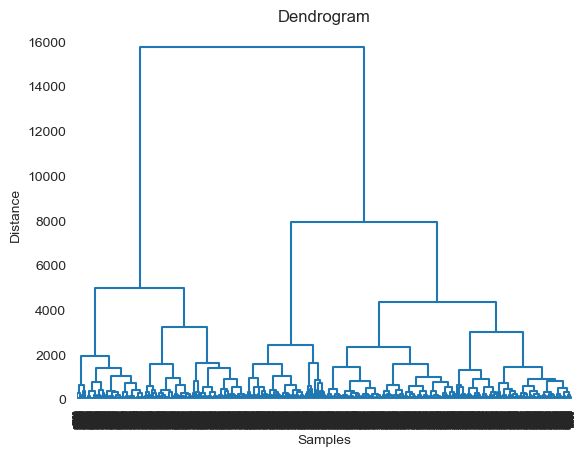


K-Means Clustering:


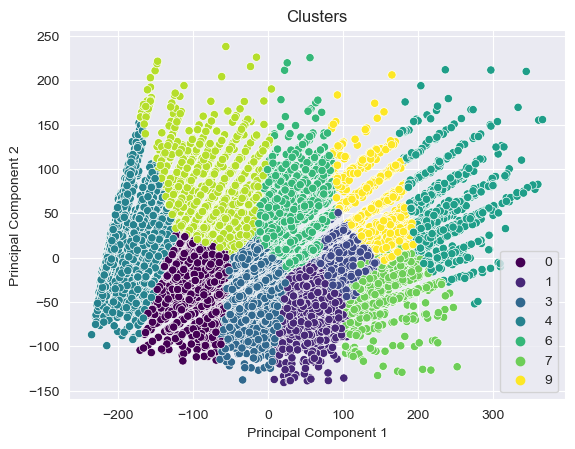


Gaussian Mixture Model:


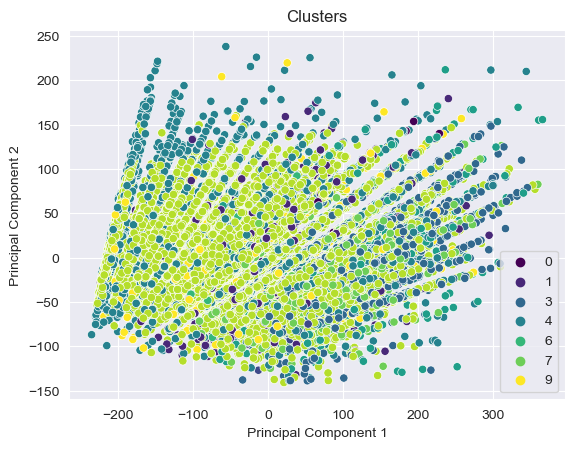


OPTICS Clustering:


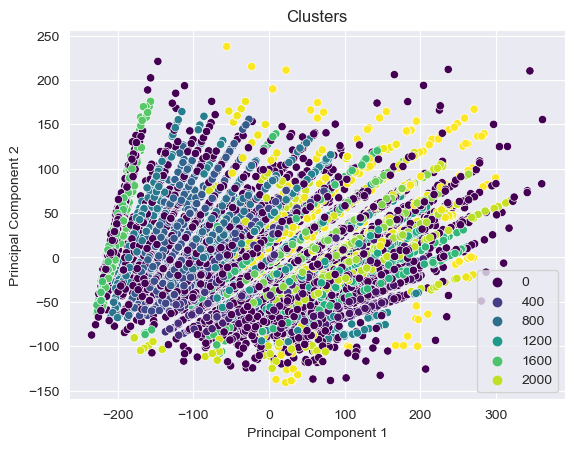

In [33]:
# Initialize the ClusteringModel class with the training and testing data
clustering_model = ClusteringModel(X_train, X_test, 10)
# Perform clustering and visualize the results
clustering_model.perform_clustering()

# Feature Selection Using the Best Model

In this section, we employ the best model identified during the model building process to perform feature selection. Feature selection is a crucial step in machine learning that involves selecting the most relevant features for model training, thereby improving model performance and reducing complexity.

Analyzing the results of the Decision Tree model with Feature Selection, we observe an accuracy of approximately 75.73%. This suggests that the model, after feature selection, performs reasonably well in classifying the data. However, it's crucial to consider both sensitivity and specificity for a more comprehensive evaluation.

The sensitivity of the model, which indicates its ability to correctly identify positive cases, is approximately 48.24%. On the other hand, the specificity, which measures the model's ability to correctly identify negative cases, is approximately 78.16%.

These results indicate that while the model has a decent ability to correctly classify negative cases (high specificity), its performance in identifying positive cases (sensitivity) is relly bad.

We serialize the feature_selector object to save its state, including the selected features. This allows us to reuse the feature selector without having to re-run the selection process.

In [34]:
# Initialize the BestFeatureSelector class with the training, testing and validation data
feature_selector = BestFeatureSelector(X_train, y_train, X_test, y_test, X_val, y_val,
                                       builder.best_model_checked(**builder.best_model_params_checked))
# Select the best features
feature_selector.select_features()

# Serialize the feature_selector object
with open('feature_selector.pkl', 'wb') as f:
    pickle.dump(feature_selector, f)

print("\nThe selected features were: ", feature_selector.selected_features_idx)

# Evaluate the model with the selected features
feature_selector.evaluate(results_dict)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/Users/dmcp2003/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/dmcp2003/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/dmcp2003/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/dmcp2003/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/


The selected features were:  (0, 2, 4, 8, 16, 18, 19, 20, 23, 24, 25)

Feature Selection Accuracy: 0.7573342430068846
Feature Selection Sensitivity: 0.48244274809160304
Feature Selection Specificity: 0.7816445014514278


# Data Demonstration and Conclusion

In this section, we demonstrate the performance of all the models and methods used in the analysis. We compare the metrics such as accuracy, sensitivity, and specificity across different models and conclude the best performing model.

After evaluating the models' performance, we conclude that __Model E (Bagging of the Decision Tree)__ stands out as the best-performing model. Here's why:
- **Accuracy:** Model E has an accuracy of 77%, the highest among all models, indicating it correctly predicts the outcomes most of the time.
- **Sensitivity:** While not the highest, Model E's sensitivity is relatively high at 67%, showing it effectively identifies positive cases.
- **Specificity:** Model E has a specificity of 67%, indicating a balanced ability to correctly identify negative cases.

Based on our analysis, Model E (Bagging of the Decision Tree) emerges as the best model due to its high accuracy and balanced performance across sensitivity and specificity. Model G (CNN) also performs well, particularly in terms of sensitivity and specificity, making it a strong contender depending on the context of the application. Model H (Decision Tree with Feature Selection) provides the highest specificity, making it useful in scenarios where correctly identifying negative cases is crucial. In summary, for balanced performance and overall accuracy, Model E is recommended. However, for tasks prioritizing sensitivity or specificity, Models G and H might be preferred, respectively.

In [35]:
# Initialize the DataDemonstration class with the results dictionary
demonstration = DataDemonstration(results_dict)
# Print the results and specifications tables
demonstration.tables()


Results Table:

     Model             Category Accuracy Sensitivity Specificity  \
0  Model A           All Models     0.55        0.69        0.69   
1  Model B  Supervised Learning     0.66        0.71        0.71   
2  Model C  Supervised Learning     0.76        0.63        0.63   
3  Model D  Supervised Learning     0.70        0.70        0.70   
4  Model E              Bagging     0.77        0.67        0.67   
5  Model F             Boosting     0.77        0.65        0.65   
6  Model G        Deep Learning     0.74        0.65        0.75   
7  Model H    Feature Selection     0.76        0.48        0.78   

                                             Remarks  
0                          Worst Performance Overall  
1  Bad Accuracy but decent Sensibility and Specif...  
2             Best Accuracy of the Supervised Models  
3  Takes the most time to execute and has bad per...  
4        Improved the best supervised model the most  
5                   Improved the best mo